# Plot gradient check results

Compare results of using a spline function to smooth `hFac` computation, and simply differentiating the regular if statements (not smooth case).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xmitgcm import open_mdsdataset

# local scripts
from readGrdchk import read_grdchk_from_stdout

In [13]:
grid = open_mdsdataset(data_dir='/workspace/grids/pig_08',
                       iters=0,ignore_unknown_vars=True,
                       geometry='sphericalpolar')
sp = read_grdchk_from_stdout('/workspace/results/pig/grdchk/grdchkEps_1m2/hfac_spline.hFacEps_1m1/STDOUT.0000')
ns = read_grdchk_from_stdout('/workspace/results/pig/grdchk/grdchkEps_1m2/not_smooth/STDOUT.0000')

/workspace/xmitgcm/xmitgcm/mds_store.py:812: UserWarning: Couldn't find available_diagnostics.log in /workspace/grids/pig_08. Using default version.
  "in %s. Using default version." % data_dir)


### Make a mesh out of the gradient check results

In [14]:
def calc_log_accuracy(grid,df):
    """
    Compute log10(input_dataframe.accuracy), handling 0's and negative values cleanly
    """
    
    # Make a container for output accuracy
    accuracy = np.NAN*grid.maskInC.values
    
    for i in np.arange(len(df.ind)):
        if df.accuracy[i] != 0:
            accuracy[df.j[i]-1,df.i[i]-1] = np.log10(np.abs(df.accuracy[i]))
        else:
            # Return a value that indicates gradient is fine...
            accuracy[df.j[i]-1,df.i[i]-1] = -4
            
    return accuracy

In [15]:
def grdchk_plotter(grid, spline_accuracy, not_smooth_accuracy):
    
    cmin = -4.5 #np.nanmin([np.nanmin(not_smooth_accuracy),np.nanmin(spline_accuracy)])
    cmax =  1.5 #np.nanmax([np.nanmax(not_smooth_accuracy),np.nanmax(spline_accuracy)])
    
    cmap = plt.get_cmap('viridis',6)
    
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.pcolormesh(grid.XC,grid.YC,spline_accuracy,
                  vmin=cmin,vmax=cmax, 
                  cmap=cmap)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.pcolormesh(grid.XC,grid.YC,not_smooth_accuracy,
                  vmin=cmin,vmax=cmax,
                  cmap=cmap)
    plt.colorbar()
    plt.show()

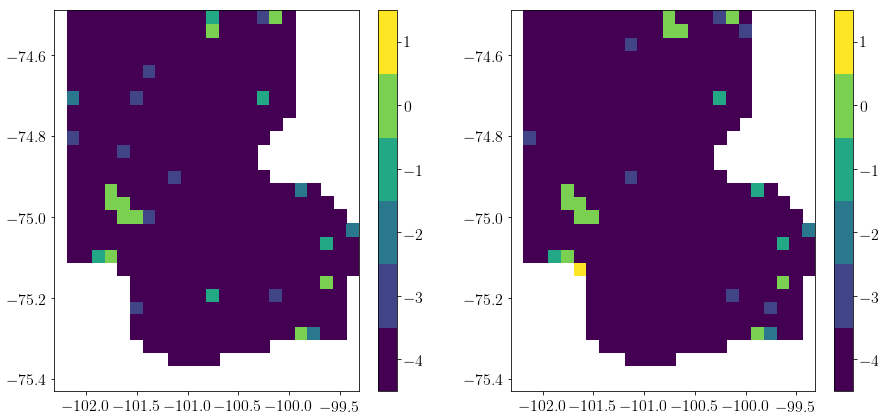

In [16]:
sp_accuracy = calc_log_accuracy(grid,sp)
ns_accuracy = calc_log_accuracy(grid,ns)

grdchk_plotter(grid,sp_accuracy,ns_accuracy)

### Now threshold points where finite difference gradient < $10^{-5}$

In [17]:
def calc_threshold_accuracy(grid,df):
    """
    Compute log10(input_dataframe.accuracy), handling 0's and negative values cleanly
    Now if finite difference < 10^-5, remove
    """
    
    # Make a container for output accuracy
    accuracy = np.NAN*grid.maskInC.values
    
    for i in np.arange(len(df.ind)):
        if (df.accuracy[i] != 0) and (np.log10(np.abs(df.grad_fd[i])) >= -5):
            accuracy[df.j[i]-1,df.i[i]-1] = np.log10(np.abs(df.accuracy[i]))
        else:
            # Return a value that indicates gradient is fine...
            accuracy[df.j[i]-1,df.i[i]-1] = -4
            
    return accuracy

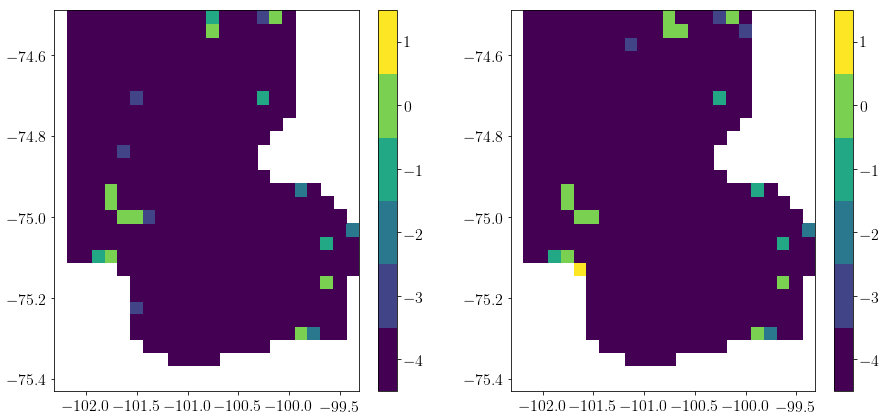

In [18]:
sp_thresh_accuracy = calc_threshold_accuracy(grid,sp)
ns_thresh_accuracy = calc_threshold_accuracy(grid,ns)

grdchk_plotter(grid,sp_thresh_accuracy,ns_thresh_accuracy)

### For points where hFac is close to hFacMin, plot the accuracy

In [19]:
def grdchk_hfac_plotter(grid, spline_accuracy, not_smooth_accuracy):
    
    cmin = -4.5 #np.nanmin([np.nanmin(not_smooth_accuracy),np.nanmin(spline_accuracy)])
    cmax =  1.5 #np.nanmax([np.nanmax(not_smooth_accuracy),np.nanmax(spline_accuracy)])
    
    cmap = plt.get_cmap('viridis',6)
    
    # Compute 2D field of points near hFacMin by hFacTol
    hFacMin = 0.1
    hFacTol = 0.1
    hFacLow = 0*grid.hFacC.isel(Z=0).values
    for k in np.arange(len(grid.Z)):
        hFacMinDiff = np.abs(grid.hFacC.isel(Z=k).values - hFacMin)
        hFacLow = np.where( hFacMinDiff < hFacTol, 1, hFacLow )
        
    # Only show accuracies at these points  
    spline_accuracy = np.where((hFacLow==1) & (spline_accuracy >= -3),spline_accuracy, -4)
    not_smooth_accuracy = np.where((hFacLow==1) & (not_smooth_accuracy >= -3),not_smooth_accuracy,-4) 
    
    msk = grid.maskInC.where(grid.maskInC.values!=0,np.NAN).values
    
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.pcolormesh(grid.XC,grid.YC,spline_accuracy * msk,
                  vmin=cmin,vmax=cmax, 
                  cmap=cmap)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.pcolormesh(grid.XC,grid.YC,not_smooth_accuracy*msk,
                  vmin=cmin,vmax=cmax,
                  cmap=cmap)
    plt.colorbar()
    plt.show()

/workspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal
/workspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater_equal


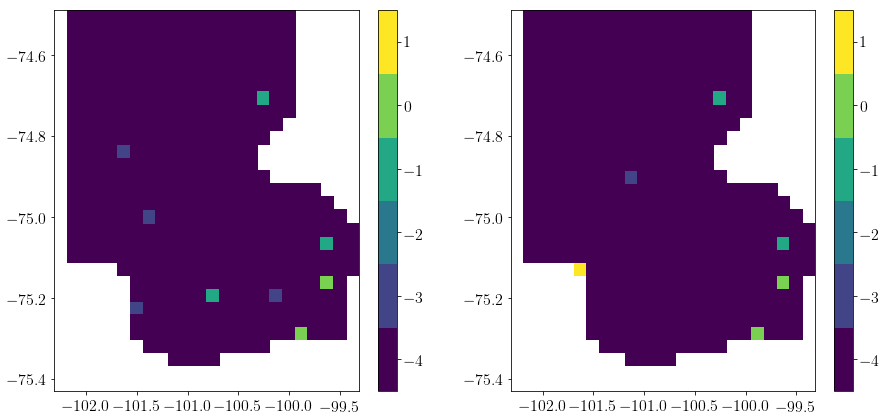

In [20]:
grdchk_hfac_plotter(grid,sp_accuracy,ns_accuracy)

So inaccurate gradients are not only at points where `hFac` is near `hFacMin`. It looks like there are also inaccuracies where $\nabla z$ is large

### Plotting gradient accuracy and $\nabla rLow$

In [21]:
import xgcm


def grdchk_bathy_grad_plotter(grid,r_value,accuracy):
    """
    r_value is either 'rLowC' or 'rSurfC', basically the z boundary we want a derivative of
    """
    
    cmin = -4.5 #np.nanmin([np.nanmin(not_smooth_accuracy),np.nanmin(spline_accuracy)])
    cmax =  1.5 #np.nanmax([np.nanmax(not_smooth_accuracy),np.nanmax(spline_accuracy)])
    
    cmap = plt.get_cmap('viridis',6)
    
    # Create an xgcm grid
    xg = xgcm.Grid(grid,periodic=False)
    
    # Use this to compute derivatives
    dr_dx = xg.diff(grid[r_value],'X',boundary='extend')
    dr_dy = xg.diff(grid[r_value],'Y',boundary='extend')
    
    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)
    plt.pcolormesh(grid.XC,grid.YC,accuracy,
                  vmin=cmin,vmax=cmax, 
                  cmap=cmap)
    plt.colorbar()
    
    cmax = np.max(np.abs(dr_dx.values))
    plt.subplot(1,3,2)
    plt.pcolormesh(grid.XC,grid.YC,dr_dx,
                   vmin=-cmax,vmax=cmax,
                  cmap='BrBG_r')
    plt.colorbar()
    plt.title(('d%s/dx' % r_value))
    
    cmax = np.max(np.abs(dr_dy.values))
    plt.subplot(1,3,3)
    plt.pcolormesh(grid.XC,grid.YC,dr_dy,
                   vmin=-cmax,vmax=cmax,
                  cmap='BrBG_r')
    plt.colorbar()
    plt.title(('d%s/dy' % r_value))
    plt.show()

In [22]:
grdchk_bathy_grad_plotter(grid,'rLowC',ns_accuracy)

KeyError: 'rLowC'

In [ ]:
grdchk_bathy_grad_plotter(grid,'rSurfC',ns_accuracy)

### Mask out points where depth is smaller than 1 depth level

In [23]:
def grdchk_zlev_plotter(grid, spline_accuracy, not_smooth_accuracy):
    
    cmin = -4.5 #np.nanmin([np.nanmin(not_smooth_accuracy),np.nanmin(spline_accuracy)])
    cmax =  1.5 #np.nanmax([np.nanmax(not_smooth_accuracy),np.nanmax(spline_accuracy)])
    
    cmap = plt.get_cmap('viridis',6)
    
    # Compute 2D field of points where depth < dZ
    dz = 2*grid.drF.values[0] # for this domain, dz is constant
    dz_mask = np.where(grid.Depth.values < dz,1,0)
    
    # Only show accuracies at these points  
    spline_accuracy = np.where((dz_mask==1) & (spline_accuracy >= -3),spline_accuracy, -4)
    not_smooth_accuracy = np.where((dz_mask==1) & (not_smooth_accuracy >= -3),not_smooth_accuracy,-4) 
    
    msk = grid.maskInC.where(grid.maskInC.values!=0,np.NAN).values
    
    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)
    plt.pcolormesh(grid.XC,grid.YC,spline_accuracy * msk,
                  vmin=cmin,vmax=cmax, 
                  cmap=cmap)
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.pcolormesh(grid.XC,grid.YC,not_smooth_accuracy*msk,
                  vmin=cmin,vmax=cmax,
                  cmap=cmap)
    plt.colorbar()
    
    plt.subplot(1,3,3)
    plt.pcolormesh(grid.XC,grid.YC,grid.Depth.where(grid.Depth.values<dz,0))
    plt.colorbar()
    plt.show()

/workspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater_equal
  del sys.path[0]
/workspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


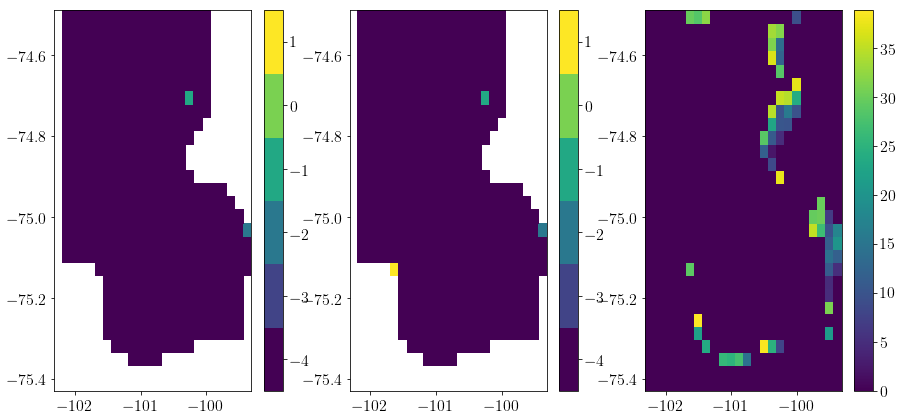

In [24]:
grdchk_zlev_plotter(grid,sp_accuracy,ns_accuracy)

## Impact of grdchkEps = $10^{-3}$

Turning down grdchk eps from $10^{-2}$ to $10^{-3}$ has little impact, seems to make grdchk less accurate in some spots...? 

In [25]:
#sp_10m3 = read_grdchk_from_stdout('/workspace/results/pig/grdchk/grdchkEps_1m3/hfac_spline.hFacEps_1m1/STDOUT.0000')
ns_10m3 = read_grdchk_from_stdout('/workspace/results/pig/grdchk/grdchkEps_1m3/not_smooth/STDOUT.0000')

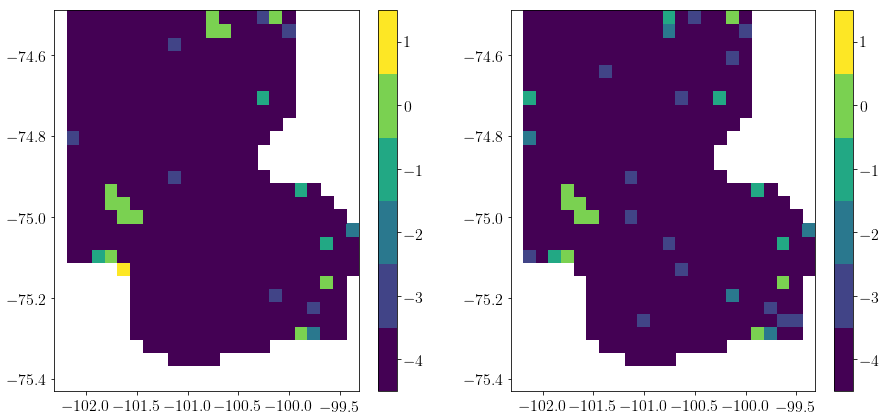

In [26]:
#sp_10m3_accuracy = calc_log_accuracy(grid,sp)
ns_10m3_accuracy = calc_log_accuracy(grid,ns_10m3)

grdchk_plotter(grid,ns_accuracy,ns_10m3_accuracy)

## Impact of `smoothHFacEps`

### First, `smoothHFacEps`=0.1 vs 0.2

In [27]:
sp_hfeps_2m1 = read_grdchk_from_stdout('/workspace/results/pig/grdchk/grdchkEps_1m2/hfac_spline.hFacEps_2m1/STDOUT.0000')


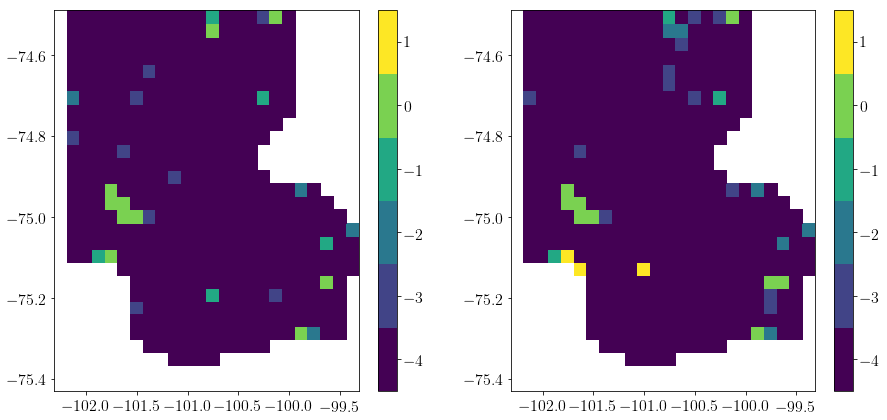

In [28]:
sp_hfeps_2m1_accuracy = calc_log_accuracy(grid,sp_hfeps_2m1)

grdchk_plotter(grid,sp_accuracy,sp_hfeps_2m1_accuracy)

### Now, `smoothHFacEps` = 0.1 vs 0.05

In [29]:
sp_hfeps_5m2 = read_grdchk_from_stdout('/workspace/results/pig/grdchk/grdchkEps_1m2/hfac_spline.hFacEps_5m2/STDOUT.0000')

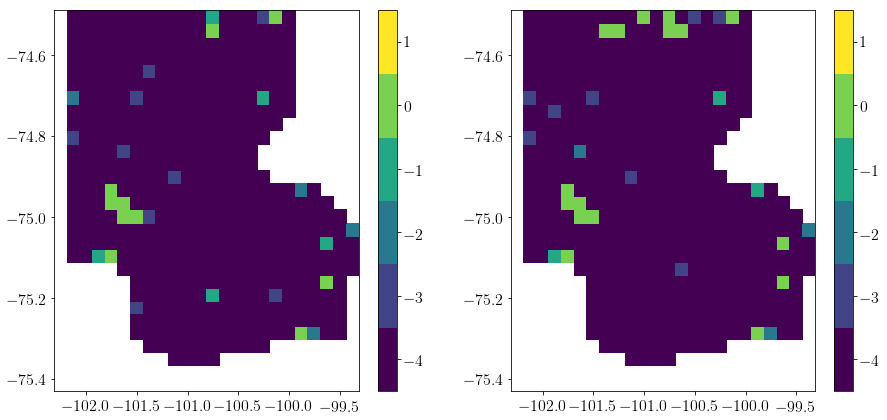

In [30]:
sp_hfeps_5m2_accuracy = calc_log_accuracy(grid,sp_hfeps_5m3)

grdchk_plotter(grid,sp_accuracy,sp_hfeps_5m2_accuracy)

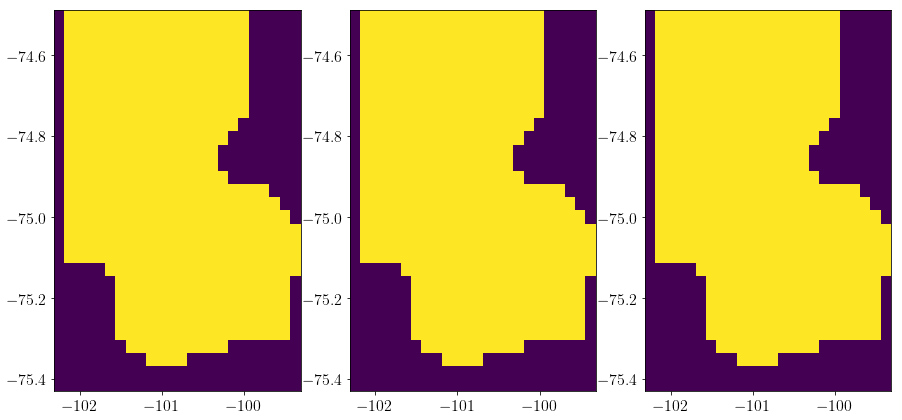

In [31]:
accuracy_msk = np.where((np.isnan(sp_accuracy)),0,1)

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.pcolormesh(grid.XC,grid.YC,accuracy_msk)
plt.subplot(1,3,2)
plt.pcolormesh(grid.XC,grid.YC,grid.maskCtrlU.isel(Z=0))
plt.subplot(1,3,3)
plt.pcolormesh(grid.XC,grid.YC,accuracy_msk + grid.maskCtrlU.isel(Z=0))
plt.show()